In [1]:
import os
import tqdm
import random
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import xgboost as xgb
from scipy import stats
from zeo_amd.classify import train_classifier, get_datasets, get_metrics, get_best_classifier
from zeo_amd.plotting import savefig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

In [3]:
X = dm.values

## Training classifiers

In [4]:
MIN_SYNTHESIS = 0.25
MIN_POSITIVE = 10
NUM_ROUNDS = 100

rng = np.random.default_rng(142)

In [5]:
results = {}

for _label in tqdm.tqdm(synth.columns):
    y = (synth[_label] > MIN_SYNTHESIS).values

    if y.sum() < MIN_POSITIVE:
        continue
    
    ensemble = []
    for n in range(NUM_ROUNDS):
        clf = get_best_classifier()
        
        seed = rng.integers(1e6 + 1)

        X_train, X_test, y_train, y_test = get_datasets(
            X, y, test_size=0.3, balanced=True, random_seed=seed,
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        cmatrix = confusion_matrix(y_test, y_pred)
        
        ensemble.append(cmatrix)
    
    results[_label] = np.array(ensemble)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:27<00:00,  2.29s/it]


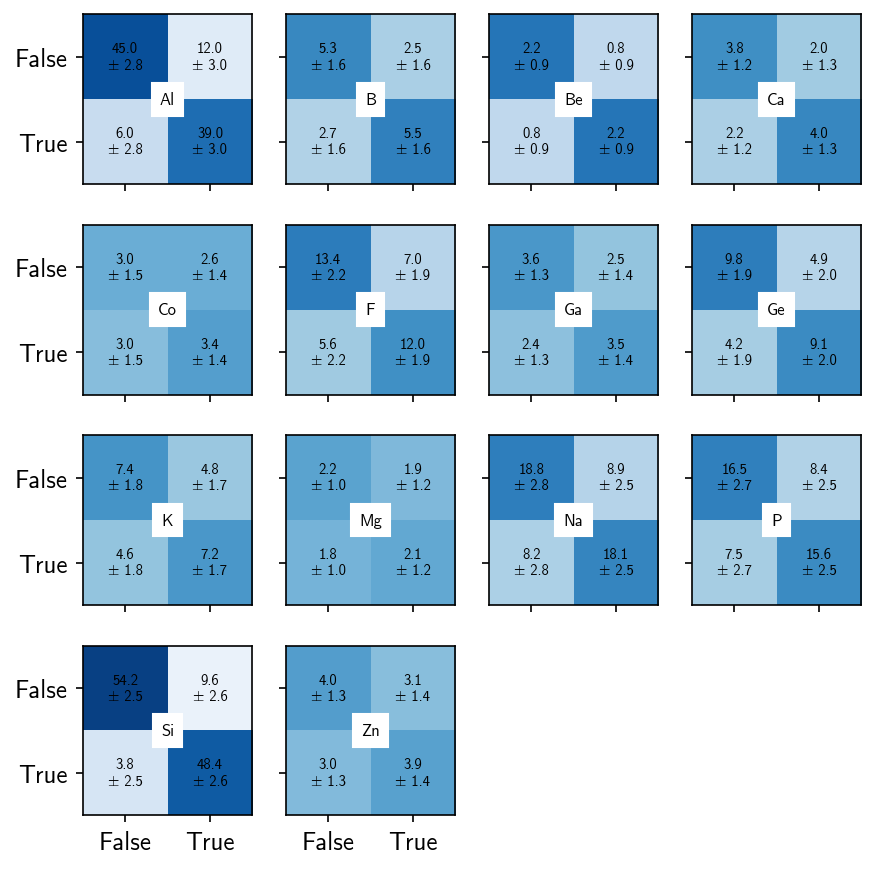

In [6]:
cmap = "Blues"
norm = plt.Normalize(0, 0.5)

fig, ax_fig = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

for n, (k, v) in enumerate(results.items()):
    ax = ax_fig.reshape(-1)[n]
    
    cmatrix = np.round(v.mean(0), 1)
    cmatrix_std = np.round(v.std(0), 1)
    colors = cmatrix / cmatrix.sum()
    
    ax.imshow(colors, norm=norm, cmap=cmap)
    
    for i, j in itertools.product([0, 1], repeat=2):
        mean = cmatrix[i, j]
        std = cmatrix_std[i, j]
        
        ax.annotate(
            f"{mean:.1f}\n± {std:.1f}",
            (i, j),
            ha="center",
            va="center",
            fontsize=7,
        )
    
    ax.annotate(
        k,
        (0.5, 0.5),
        fontsize=8,
        ha="center",
        va="center",
        backgroundcolor='#ffffff',
    )
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["False", "True"])
    ax.set_yticklabels(["False", "True"])
    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")

fig.tight_layout()
savefig(fig, "04-classifier-confusion.pdf")
plt.show()